<h1> Random Proportion Modelling </h1>

In [1]:
# Load Libraries

import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from numpy import linalg as la
from random import sample

# Setting Constants

TI_limit = 25; 
TR = 7500; # (7.5 sesconds) T1 affects next slive

In [2]:
# Loading in Image 

img_nifti = nib.load("cdmri11_r.nii")

img =img_nifti.dataobj[:,:,:,:]


In [3]:
img.shape

(77, 92, 56, 1344)

In [4]:
# Loading in Mask

mask_nifti = nib.load("cdmri11_mask.nii")

mask = mask_nifti.dataobj[:,:,:]

In [5]:
# Final Image 

arr = img.copy()
for i in range (0,1344):
    arr[:,:,:,i] = mask*img[:,:,:,i]; 

In [6]:
arr.shape

(77, 92, 56, 1344)

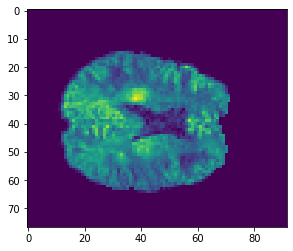

In [7]:
plt.imshow(arr[:,:,33,200])

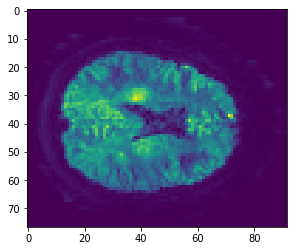

In [8]:
plt.imshow(img[:,:,33,200])

In [9]:
MD_map = np.zeros([77,92])

T1_map = np.zeros([77,92])
T2_map = np.zeros([77,92])
IE_map = np.zeros([77,92])

cost_map = np.zeros([77,92])
D_map = np.zeros([77,92,3,3])
FA_map = np.zeros([77,92])

MD_map_abs = np.zeros([77,92])

In [10]:
# Importing Parameters

p = np.loadtxt('parameters_new.txt')
p.shape

(1344, 6)

In [11]:
param = np.zeros([1344,6])
param = p.copy()
# Switching first two columns as:
# [x y z] --> [y -x z] (scanner to measurement coordinate system)
param[:, 0], param[:, 1] = p[:, 1], p[:, 0].copy()
param[:,1] = -param[:,1]

# had to check, but is correct
# np.savetxt('changed_param.txt', param, fmt='%1.5f')

param

array([[-7.1803e-01,  5.2602e-01, -4.5578e-01,  3.0000e+03,  2.0000e+01,
         8.0000e+01],
       [-7.1803e-01,  5.2602e-01, -4.5578e-01,  3.0000e+03,  1.2364e+03,
         8.0000e+01],
       [-7.1803e-01,  5.2602e-01, -4.5578e-01,  3.0000e+03,  2.4727e+03,
         8.0000e+01],
       ...,
       [-6.8361e-01, -4.9906e-01,  5.3255e-01,  2.0000e+03,  2.2961e+03,
         1.3000e+02],
       [-6.8361e-01, -4.9906e-01,  5.3255e-01,  2.0000e+03,  3.5325e+03,
         1.3000e+02],
       [-6.8361e-01, -4.9906e-01,  5.3255e-01,  2.0000e+03,  7.3227e+03,
         1.3000e+02]])

In [12]:
b = p[:,3]
TI = p[:,4]
TE = p[:,5]

# Filter based on TI fulfilling condition
vals = TI>TI_limit
indices = np.where(TI>TI_limit)
b0idx = np.where(b==0)   

TI=TI[indices]
TE=TE[indices]
param=param[indices]
b=b[indices]
res_selected = arr[:,:,:,indices]

In [13]:
# From Stackoverflow: https://stackoverflow.com/questions/45637778/how-to-find-intersect-indexes-and-values-in-python
# Function takes unique elements from each array, puts them together, and concatenates
import numpy as np
def intersect_mtlb(a, b):
    a1, ia = np.unique(a, return_index=True)
    b1, ib = np.unique(b, return_index=True)
    aux = np.concatenate((a1, b1))
    aux.sort()
    c = aux[:-1][aux[1:] == aux[:-1]]
    return c, ia[np.isin(a1, c)], ib[np.isin(b1, c)]

c, idx_b0, ib = intersect_mtlb(indices, b0idx )

# s0init = np.mean(arr[:,:,:,idx_b0], axis = 3) 

# Initial Values and Objective Function
b=b/1000
x0 = [300, 2, 1000, 100, 1, 1, 1,0,0,0]

boundaries = [0, 1, 0, 10, 0, 0, 0, -np.inf, -np.inf, -np.inf], [np.inf, 2, 2e7, 350, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]

# Note: Thilo has no bounds on fit

<h2> Selecting for Separate Effects </h2>

In [14]:
# Extract indices

# Diffusion
low_TE_ind = np.where(TE<100)
high_TI_ind = np.where(TI>4600) # First trial was 1500
diff_ind_1 = np.intersect1d(high_TI_ind, low_TE_ind, assume_unique=True)

# T1
low_TE_ind = np.where(TE<100)
b_ind = np.where(b==0)
diff_ind_2 = np.intersect1d(b_ind, low_TE_ind, assume_unique=True)

# T2
high_TI_ind = np.where(TI>3200)
b_ind = np.where(b==0)
diff_ind_3 = np.intersect1d(b_ind, high_TI_ind, assume_unique=True)

In [15]:
# Combining
diff_ind = np.concatenate((diff_ind_1, diff_ind_2, diff_ind_3))

In [16]:
# Select Relevant Data
b = b[diff_ind]
TI = TI[diff_ind]
TE = TE[diff_ind]
param = param[diff_ind,:]
res_selected = res_selected[:,:,:,:,diff_ind]

<h2> Creating Model </h2>

In [17]:
# Fit Function

def Fit(x,b, TI, TR, TE, param):            

    S= np.abs(x[0] *(1-x[1]* np.exp(-TI/x[2])+np.exp(-TR/x[2]))* np.exp(-TE/x[3])* np.exp(-b*(np.square(param[:,0])*x[4]+np.square(param[:,1])*x[5]+np.square(param[:,2])*x[6]+2*param[:,0]*param[:,1]*x[7]+2*param[:,0]*param[:,2]*x[8]+2*param[:,1]*param[:,2]*x[9])))
    return S

# Simple Exponential Cost Function

def FitCost(x, b, TI, TR, TE, param, slslice):   
    # x[0] : Amplitude
    # x[1] : D value
    
    S= np.abs(x[0] *(1-x[1]* np.exp(-TI/x[2])+np.exp(-TR/x[2]))* np.exp(-TE/x[3])* np.exp(-b*(np.square(param[:,0])*x[4]+np.square(param[:,1])*x[5]+np.square(param[:,2])*x[6]+2*param[:,0]*param[:,1]*x[7]+2*param[:,0]*param[:,2]*x[8]+2*param[:,1]*param[:,2]*x[9])))
    res = slslice[0,:] -S
    return res

In [18]:


def MD(b, TI, TR, TE, param, slslice, boundaries):

    # Perform Non-Linear Least Squares Fit

    x0 = [300, 2, 1000, 100, 1, 1, 1,0,0,0]
    # for x[4], values of 0.01, 1 would lead to a straight line at 0, 
    # while 10 and 100 works fine

    lsr = least_squares(FitCost, x0, args=(b,TI, TR, TE, param, slslice), bounds=(boundaries), max_nfev=5000)
    cost = lsr.cost
    jac = lsr.jac
    values = lsr.x

    # Computing Mean Diffusivity
    # Diffusion Tensor
    D = [[values[4], values[7], values[8]], 
         [values[7], values[5], values[9]], 
         [values[8], values[9], values[6]]]

    # Eigenvectors and Eigenvalues 
    [evecs , evals] = la.eig(D)
    i = np.argsort(np.diag(evals))
    evals = np.diag(evals)[i]

    # Calculating MD 
    MD = (evals[0]+evals[1]+evals[2])/3
    return MD


def Maps(b, TI, TR, TE, param, slslice, boundaries):

    # Perform Non-Linear Least Squares Fit

    x0 = [300, 2, 1000, 100, 1, 1, 1,0,0,0]
    # for x[4], values of 0.01, 1 would lead to a straight line at 0, 
    # while 10 and 100 works fine

    lsr = least_squares(FitCost, x0, args=(b,TI, TR, TE, param, slslice), bounds=(boundaries), max_nfev=5000)
    cost = lsr.cost
    jac = lsr.jac
    values = lsr.x

    # Computing Mean Diffusivity
    # Diffusion Tensor
    D = [[values[4], values[7], values[8]], 
         [values[7], values[5], values[9]], 
         [values[8], values[9], values[6]]]

    # Eigenvectors and Eigenvalues 
    [evals , evecs] = la.eig(D)
    
    # Calculating MD 
    MD = (evals[0]+evals[1]+evals[2])/3
    FA = np.sqrt(1/2)*((np.sqrt((evals[0]-evals[1])**2+(evals[1]-evals[2])**2+(evals[2]-evals[0])**2))/np.sqrt(evals[0]**2+evals[1]**2+evals[2]**2))
    return MD, values[1],values[2],values[3], cost, FA

    # values[3]: T2* , [2]: T1, [1]: PD?, i.e. IE

In [19]:
# Initializations
results = np.zeros((77, 92, 56, 6))

# Saving parameters chose
np.savetxt('combined_modelling.txt', diff_ind )

# Loop through Voxels
for k in range (56):
    for i in range (77):
        for j in range (92):
            slslice = res_selected[i,j,k,:]
            # MD_map[i,j], IE_map[i,j],T1_map[i,j],T2_map[i,j], cost_map[i,j], FA_map[i,j]= Maps(b, TI, TR, TE, param, slslice, boundaries)
            results[i,j,k,0], results[i,j,k,1],results[i,j,k,2],results[i,j,k,3], results[i,j,k,4], results[i,j,k,5]= Maps(b, TI, TR, TE, param, slslice, boundaries)

# Saving Array as Nifti
nifti_img = nib.Nifti1Image(results, affine = None)
nib.save(nifti_img, 'combined_modelling.nii')

KeyboardInterrupt: 